# **Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms as T
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt

# **Inits**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 100

mnist_dim = 28*28

n_g = 256

z_dim = 100

lr = 0.0002

n_epochs = 400

# **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Dataset**

In [ ]:
transform = T.Compose([T.ToTensor(),
                       T.Normalize(0.5, 0.5)])

In [ ]:
dataset = MNIST('./mnist', True, transform, download=True)

In [ ]:
dataset.data.shape

torch.Size([60000, 28, 28])

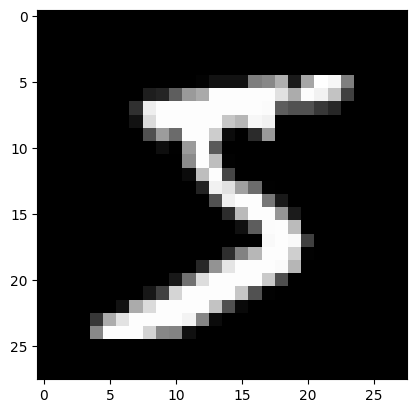

In [ ]:
plt.imshow(dataset.data[0], cmap='gray')

In [ ]:
dataloader = DataLoader(dataset, batch_size, True)

In [ ]:
x, y = next(iter(dataloader))

In [ ]:
x.shape, y.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [ ]:
img_grid = make_grid(x, 10)
img_grid[0].shape

torch.Size([302, 302])

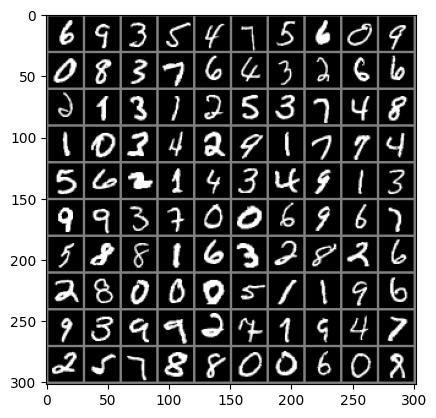

In [ ]:
plt.imshow(img_grid[0], cmap='gray')

# **Models**

## Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, n=256):
    super(Generator, self).__init__()

    self.fc1 = nn.LazyLinear(n)
    self.fc2 = nn.LazyLinear(n*2)
    self.fc3 = nn.LazyLinear(n*4)
    self.fc4 = nn.LazyLinear(mnist_dim)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.leaky_relu(self.fc3(x), 0.2)
    y = torch.tanh(self.fc4(x))
    return y

In [ ]:
G = Generator(n_g)
G

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Generator(
  (fc1): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=784, bias=True)
)

In [ ]:
G(torch.randn(10, z_dim)).shape

torch.Size([10, 784])

## Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.fc1 = nn.LazyLinear(1024)
    self.fc2 = nn.LazyLinear(512)
    self.fc3 = nn.LazyLinear(256)
    self.fc4 = nn.LazyLinear(1)

  def forward(self, x):
    x = F.dropout(F.leaky_relu(self.fc1(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc2(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc3(x), 0.2), 0.3)
    y = torch.sigmoid(self.fc4(x))
    return y

In [ ]:
D = Discriminator()
D

Discriminator(
  (fc1): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=1, bias=True)
)

In [ ]:
xf = x.flatten(1)

In [ ]:
D(xf).shape

torch.Size([100, 1])

# **Train**

In [ ]:
loss_D_hist, loss_G_hist = [], []

In [ ]:
for epoch in range(n_epochs):
  loss_D_avg, loss_G_avg = AverageMeter(), AverageMeter()
  for x, _ in dataloader:
    #----------------------------------------------------------------------
    # Discriminator
    #----------------------------------------------------------------------
    D.zero_grad()

    # real data
    x_real = x.flatten(1).to(device)
    y_real = torch.ones(batch_size, 1).to(device)

    # real -> D
    D_output = D(x_real)
    D_loss = loss_fn(D_output, y_real)

    # noise & fake label
    z = torch.randn(batch_size, z_dim).to(device)
    y_fake = torch.zeros(batch_size, 1).to(device)

    # fake data: noise -> G
    x_fake = G(z)

    # fake -> D
    G_output = D(x_fake)
    G_loss = loss_fn(G_output, y_fake)

    # total loss D
    D_loss = G_loss + D_loss

    # optimization
    D_loss.backward()
    D_optimizer.step()

    #----------------------------------------------------------------------
    # Generator
    #----------------------------------------------------------------------
    G.zero_grad()

    z = torch.randn(batch_size, z_dim).to(device)
    y_real = torch.ones(batch_size, 1).to(device)

    # noise -> G -> D
    output = D(G(z))

    # loss
    G_loss = loss_fn(output, y_real)

    # optimization
    G_loss.backward()
    G_optimizer.step()

    loss_D_avg.update(D_loss.item())
    loss_G_avg.update(G_loss.item())

  loss_D_hist.append(loss_D_avg.avg)
  loss_G_hist.append(loss_G_avg.avg)

  with torch.no_grad():
    bs = 64
    z_test = torch.randn(bs, z_dim).to(device)
    outputs = G(z_test)
    save_image(outputs.view(bs, 1, 28, 28), f'./images/gan-{epoch:03d}.png')

  print(f'{epoch}/{n_epochs}: D Loss: {loss_D_avg.avg:.4f}, G Loss: {loss_G_avg.avg:.4f}')


0/400: D Loss: 0.9337, G Loss: 2.8409
1/400: D Loss: 1.1055, G Loss: 1.5657
2/400: D Loss: 0.7299, G Loss: 2.6654
3/400: D Loss: 0.5707, G Loss: 3.1084
4/400: D Loss: 0.4739, G Loss: 3.4004
5/400: D Loss: 0.5542, G Loss: 2.9987
6/400: D Loss: 0.4940, G Loss: 2.9981
7/400: D Loss: 0.5570, G Loss: 2.6945
8/400: D Loss: 0.5837, G Loss: 2.5858
9/400: D Loss: 0.6405, G Loss: 2.4658
10/400: D Loss: 0.6127, G Loss: 2.4519
11/400: D Loss: 0.7245, G Loss: 2.2157
12/400: D Loss: 0.7148, G Loss: 2.1582
13/400: D Loss: 0.7439, G Loss: 2.0514
14/400: D Loss: 0.8030, G Loss: 1.9379
15/400: D Loss: 0.8138, G Loss: 1.8560
16/400: D Loss: 0.8267, G Loss: 1.8067
17/400: D Loss: 0.8736, G Loss: 1.7091
18/400: D Loss: 0.9040, G Loss: 1.6208
19/400: D Loss: 0.9381, G Loss: 1.5424
20/400: D Loss: 0.9481, G Loss: 1.5030
21/400: D Loss: 0.9207, G Loss: 1.5949
22/400: D Loss: 0.9226, G Loss: 1.6311
23/400: D Loss: 0.9346, G Loss: 1.5629
24/400: D Loss: 0.9450, G Loss: 1.5424
25/400: D Loss: 0.9910, G Loss: 1.4

# **Evaluation**

In [ ]:
with torch.no_grad():
  bs = 64
  test_z = torch.randn(bs, z_dim).to(device)
  outputs = G(test_z)
  save_image(outputs.view(bs, 1, 28, 28), f'./images/gan.png')

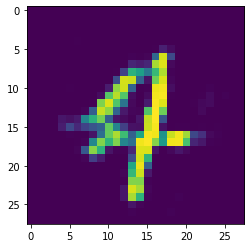

In [ ]:
plt.imshow(outputs.view(-1, 1, 28, 28)[0, 0].cpu())

In [ ]:
D.eval()
with torch.inference_mode():
  real_fake = D(outputs)
real_flags = real_fake > 0.5

In [ ]:
real_flags.sum()/bs

tensor(0.2500, device='cuda:0')

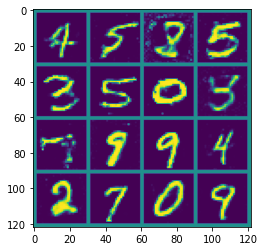

In [ ]:
output_G = outputs.view(-1, 1, 28, 28)
plt.imshow(make_grid(output_G[real_flags.squeeze()].cpu(), 4)[0])

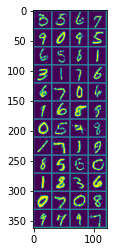

In [ ]:
fakes = torch.logical_not(real_flags.squeeze())
plt.imshow(make_grid(output_G[fakes].cpu(), 4)[0])

# **Plot 📈**

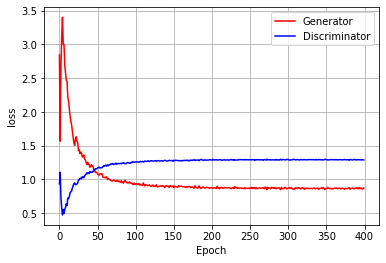

In [ ]:
plt.plot(range(epoch+1), loss_G_hist, 'r-', label='Generator')
plt.plot(range(epoch+1), loss_D_hist, 'b-', label='Discriminator')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()